In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark

In [6]:
! cp drive/MyDrive/CNTT/MMDS/GK-eng/baskets.csv .

In [65]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

In [66]:
import findspark
findspark.init()

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession, DataFrame, Row
from pyspark.sql.types import StringType
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, ArrayType

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import os
import shutil
import pandas as pd
from itertools import combinations

In [2]:
spark = SparkSession.builder \
                    .appName("MMDS") \
                    .getOrCreate()

# Process Baskets

## list of baskets are sorted in the ascending order of year, month, day.

In [3]:
df = spark.read.csv('baskets.csv',
                    header=True, inferSchema=True)


baskets = df.groupBy('Member_number', 'year', 'month', 'day', 'Date') \
            .agg(F.collect_set("itemDescription").alias("Baskets")) \
            .orderBy(['year', 'month', 'day'], ascendingOrder = True)


baskets.show(5, truncate = False)

+-------------+----+-----+---+----------+---------------------------------------------+
|Member_number|year|month|day|Date      |Baskets                                      |
+-------------+----+-----+---+----------+---------------------------------------------+
|1922         |2014|1    |1  |01/01/2014|[tropical fruit, other vegetables]           |
|2610         |2014|1    |1  |01/01/2014|[domestic eggs, bottled beer, hamburger meat]|
|2226         |2014|1    |1  |01/01/2014|[sausage, bottled water]                     |
|1789         |2014|1    |1  |01/01/2014|[candles, hamburger meat]                    |
|2237         |2014|1    |1  |01/01/2014|[Instant food products, bottled water]       |
+-------------+----+-----+---+----------+---------------------------------------------+
only showing top 5 rows



## line chart to visualize the number of baskets bought in each date.

In [4]:
total_baskets_each_date = baskets.groupBy('Date') \
                                  .count() \
                                  .orderBy(F.to_date(F.col('Date'), 'dd/MM/yyyy'), ascendingOrder = True)

total_baskets_each_date.show(5)

+----------+-----+
|      Date|count|
+----------+-----+
|01/01/2014|   21|
|02/01/2014|   29|
|03/01/2014|   24|
|04/01/2014|   28|
|05/01/2014|   20|
+----------+-----+
only showing top 5 rows



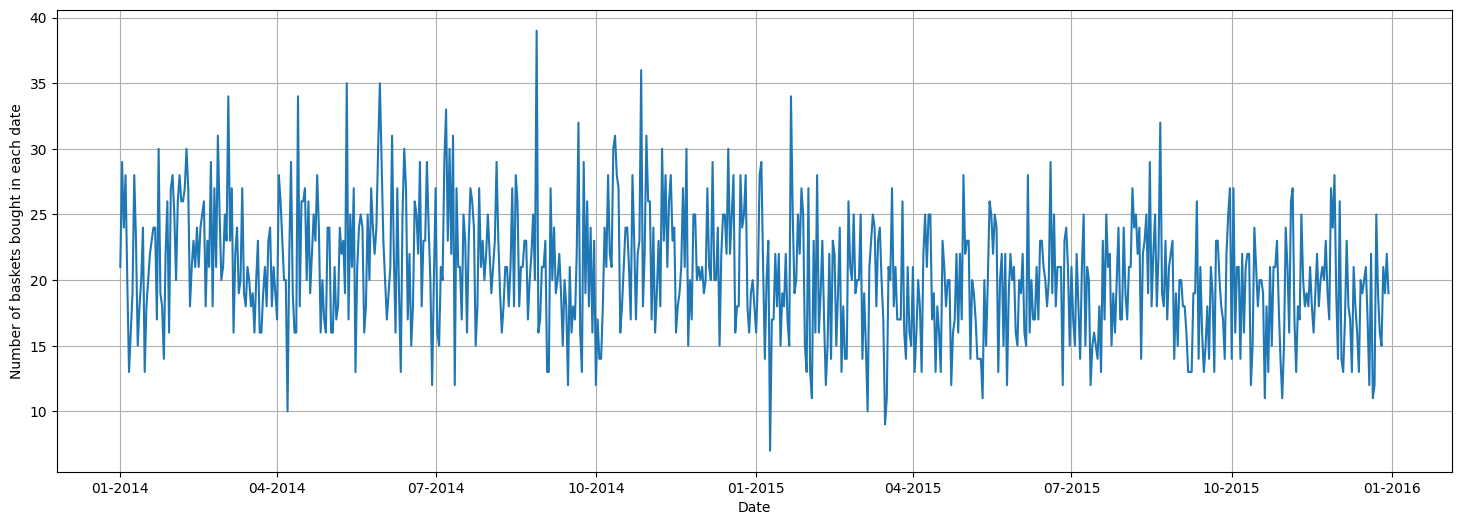

In [5]:
pdf = total_baskets_each_date.withColumn('Date', F.to_date(F.col('Date'), 'dd/MM/yyyy')).toPandas()
fig, ax = plt.subplots(figsize=(18, 6))

date = pdf['Date'].values.tolist()
baskets_count = pdf['count'].values.tolist()

date_form = DateFormatter("%m-%Y")
ax.xaxis.set_major_formatter(date_form)

plt.plot(date, baskets_count)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Number of baskets bought in each date')
plt.show()

## Save the resulting baskets in the folder baskets.

In [6]:
baskets.withColumn('Baskets', F.concat_ws(",", F.col("Baskets"))) \
                    .select('Baskets') \
                    .write.format("csv") \
                    .mode('overwrite') \
                    .option("header","true") \
                    .save("./baskets")

baskets.withColumn('Baskets', F.concat_ws(",", F.col("Baskets"))) \
                    .select('Baskets') \
                    .show(5, truncate = False)
# print(baskets.count())

+-----------------------------------------+
|Baskets                                  |
+-----------------------------------------+
|tropical fruit,other vegetables          |
|domestic eggs,bottled beer,hamburger meat|
|sausage,bottled water                    |
|candles,hamburger meat                   |
|Instant food products,bottled water      |
+-----------------------------------------+
only showing top 5 rows



# PCY Algorithm


In [7]:
class PCY:
    def __init__(self, path: str, support: float, confid: float, bucket_size = 1000):
        self.path = path
        self.s = support
        self.c = confid
        self.bucket_size = bucket_size

        self.spark = SparkSession.builder \
                                  .appName("PCY") \
                                  .getOrCreate()

        self.data = self.read_baskets()
        self.size = self.data.count()

    @staticmethod
    @F.udf(returnType = StringType())
    def tuple_to_string(t):
        return ', '.join(t)


    def association_rules(self, frequent_pairs, frequent_items):
        confidence = self.c
        size = self.size

        def powerset(s):
          x = len(s)
          power_set = list()
          for i in range(1 << x):
              subset = [s[j] for j in range(x) if (i & (1 << j))]

              if len(subset) != 0 and len(subset) != x:
                  power_set.append(subset)

          return power_set

        # create powerset of frequent pairs
        power_set = frequent_pairs.map(lambda x: [powerset(x[0]), x[1]])

        # generate rule and convert to DataFrame

        def generate_rules(power_set):
          rules = []
          for x in power_set[0]:
              for y in power_set[0]:
                  if not set(x).issubset(set(y)) or x != y:
                      rules.append((x, y, power_set[1]))
          return rules

        rules = power_set.flatMap(lambda x: generate_rules(x))
        rules = rules.toDF(['antecedent', 'consequent' , 'freq'])
        rules = rules.withColumn('support', F.col('freq') / size)

        # create frequent items DataFrame
        frequent_items_df = self.spark.createDataFrame([Row(items=[x], freq_items=y) for x, y in frequent_items.items()])

        # association rule
        assoc_rules_df = rules.join(
            frequent_items_df,
            on=(rules['antecedent'] == frequent_items_df['items']),
            how='inner'
        ).select(
            'antecedent',
            'consequent',
            'freq',
            'support',
            frequent_items_df["freq_items"].alias('antecedent_support')
        )

        assoc_rules_df = assoc_rules_df.withColumn('confidence', F.col('freq') / F.col('antecedent_support')) \
                      .filter(F.col('confidence') > confidence) \
                      .select(
                            'antecedent',
                            'consequent',
                            'confidence',
                            'support'
                      ) \
                      .withColumn('antecedent', F.concat_ws(",", F.col("antecedent"))) \
                      .withColumn('consequent', F.concat_ws(",", F.col("consequent")))

        return assoc_rules_df


    def run(self):
        size = self.size
        support = self.s
        bucket_size = self.bucket_size

        # Pass 1: Count the frequency of each item
        combined_counts = self.data.rdd.flatMap(lambda x: [
            # Emit individual items with a tag
            (('item', item), 1) for item in x.Baskets
        ] + [
            # Emit hashed buckets for pairs with a tag
            (('bucket', abs(hash(pair)) % bucket_size), 1) for pair in combinations(x.Baskets, 2)
        ]).reduceByKey(lambda x, y: x + y)

        # Split the combined counts into items and buckets
        frequent_items = combined_counts.filter(lambda x: x[0][0] == 'item') \
                                        .map(lambda x: (x[0][1], x[1])) \
                                        .filter(lambda x: x[1] / size >= support) \
                                        .collectAsMap()

        frequent_buckets = combined_counts.filter(lambda x: x[0][0] == 'bucket') \
                                          .map(lambda x: (x[0][1], x[1])) \
                                          .filter(lambda x: x[1] / size >= support) \
                                          .collectAsMap()

        # Pass 2:
        all_pairs = self.data.rdd.flatMap(lambda x: combinations(x.Baskets, 2))

        frequent_pairs = all_pairs.filter(lambda x: abs(hash(x)) % bucket_size in frequent_buckets) \
                                  .filter(lambda x: x[0] in frequent_items) \
                                  .map(lambda x: (x, 1)) \
                                  .reduceByKey(lambda x, y: x + y) \
                                  .filter(lambda x: x[1] / size >= support)

        # association rule
        association_rule = self.association_rules(frequent_pairs, frequent_items)


        # Save result to csv file
        frequent_pairs = frequent_pairs.toDF(['freqPairs', 'freq']) \
                      .withColumn('freqPairs', F.concat_ws(",", self.tuple_to_string(F.col("freqPairs"))))


        self.save(frequent_pairs, 'pcy_frequent_pairs.csv')
        self.save(association_rule, 'pcy_association_rules.csv')

        return frequent_items, frequent_pairs, association_rule


    def read_baskets(self):
        # Read baskets from CSV file
        baskets = self.spark.read.csv(self.path,
                                        header= True,
                                        inferSchema=True)

        baskets = baskets.withColumn("Baskets", F.split(baskets["Baskets"], ","))
        return baskets


    def save(self, df: DataFrame, name: str):
        temp_dir = "temp"
        df.coalesce(1).write.option("header", "true").mode('overwrite').csv(temp_dir)

        # Get the name of the CSV file
        csv_file = [file for file in os.listdir(temp_dir) if file.endswith('.csv')][0]

        # Move and rename the CSV file to the target directory
        shutil.move(os.path.join(temp_dir, csv_file), name)

        shutil.rmtree(temp_dir)

    def __del__(self):
        self.spark.stop()


job = PCY('./baskets', support = 0.012, confid = 0.1)
frequent_items, frequent_pairs, association_rules = job.run()

In [8]:
frequent_pairs.show()

+--------------------+----+
|           freqPairs|freq|
+--------------------+----+
|whole milk, other...| 222|
|whole milk, rolls...| 209|
+--------------------+----+



In [9]:
association_rules.show()

+----------------+----------+-------------------+--------------------+
|      antecedent|consequent|         confidence|             support|
+----------------+----------+-------------------+--------------------+
|other vegetables|whole milk|0.12151067323481117|0.014836596939116486|
|      rolls/buns|whole milk|0.12697448359659783|0.013967787208447505|
+----------------+----------+-------------------+--------------------+

